In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from matplotlib import cm
plt.rcParams['font.size'] = 14
plt.rcParams['axes.spines.right'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.top'] = False

###  Regularized optimization problems
In practice, we often encounter situations where we would like to estimate lots of parameters but where we don't really have enough data. One possible solution is then to use prior knowledge to favor some parameter combinations over others. For example, if we know that many parameters are likely to be zero, then one possibility is to add a regularization term to our objective function that promotes sparse solutions. However, some commonly used regularization terms are not smooth functions, and consequently, we can no longer use simple gradient based methods for finding the optimal parameters. Here, we therefore introduce a method called proximal gradient, which is used for minimizing non-differentiable functions that can be divided into a sum of two convex functions: one smooth and differentiable, and one non-differentiable.

### Objective function with $L^1$ regularization
Building upon our previous Poisson regression example, we note that we can promote sparse solutions by adding an $L^1$ regularization term (also known as lasso-regularization as it shrinks dimensions to zero one at a time). Our new objective function thus takes the form:
\begin{align*}
 nll(w_0, w_1) &= \sum_i^N f(z_i) - y_i\log(f(z_i)) + \lambda ||\mathbf{w}||_{L^1},\\
 ||\mathbf{w}||_{L^1} &= \sum_j |w_j| = |w_1| + |w_2|,          
\end{align*}
where $\lambda$ is a regularization parameter that adjust how heavily we penalize non-zero parameter values. Observe that we still refer to this objective function as the negative log-likelihood ($nll$), as the additional regularization term only corresponds to adding a Laplacean zero mean prior on our parameters. However, the objective function is now composed of two parts, which we can highlight by writing it as:
\begin{align*}
 nll(\mathbf{w}) &= g(\mathbf{w}) + h(\mathbf{w}),\\
 g(\mathbf{w})   &=\sum_i^N f(z_i) - y_i\log(f(z_i)),\\
 h(\mathbf{w})   &= ||\mathbf{w}||_{L^1}.          
\end{align*}
The first part ($g$) is convex and differentiable, whereas the second part ($h$) is convex (as it is a norm) but non-differentiable.

In [2]:
# Poisson regression, rectified inverse link function
def invLinkFun(X, w):
    z = np.dot(X, w)
    mu = np.zeros(z.shape)
    mu[z<0] = np.exp(z[z<0])
    mu[z>=0] = z[z>=0] + 1
    return mu

# Poisson regression, negative log-likelihood
gFun = lambda X, y, w: np.sum(invLinkFun(X, w) - y*np.log(invLinkFun(X, w)))

# L1 regularization term
hFun = lambda w, reg_lambda: reg_lambda*np.linalg.norm(w)

# Negative log-likelihood
negLogLikFun = lambda X, y, w, reg_lambda: gFun(X, y, w) + hFun(w, reg_lambda)

# Poisson regression, gradient of the negative log-likelihood
def gDerFun(X, y, w):
    z = np.dot(X, w)
    der = np.dot(np.exp(z[z<0])-y[z<0], X[z<0, :])
    der += np.dot(1-y[z>=0]/(z[z>=0]+1), X[z>=0, :])
    return der

### Proximal gradient
To introduce the logic behind the proximal gradient method, we begin by performing a quadratic expansion of $g$ around $\mathbf{w}_k$:
$$
g(\mathbf{w}_k)+\nabla g(\mathbf{w}_k)^T(\mathbf{w}-\mathbf{w}_k)+\frac{1}{2\eta}||\mathbf{w}-\mathbf{w}_k||^2_2
$$
where the Hessian is approximated by $\frac{1}{\eta}\mathbf{I}$. Differentiating the expansion with respect to $\mathbf{w}$ gives:
$$
\nabla g(\mathbf{w}_k) + \frac{1}{\eta}(\mathbf{w}-\mathbf{w}_k),
$$
which results in $\mathbf{w}_{k+1}=\mathbf{w}=\mathbf{w}_k - \eta\nabla g(\mathbf{w}_k)$ when set to zero. That is, we see that the normal gradient descent rule corresponds to minimizing a quadratic expansion around our current parameter values when the Hessian is approximated as $\frac{1}{\eta}\mathbf{I}$. A logical continuation is then to ask what kind of update rule we get if we seek to minimize the quadratic approximation plus the regularization term:
$$
\underset{\mathbf{w}}{\operatorname{argmin}} g(\mathbf{w}_k)+\nabla g(\mathbf{w}_k)^T(\mathbf{w}-\mathbf{w}_k)+\frac{1}{2\eta}||\mathbf{w}-\mathbf{w}_k||^2_2 + h(\mathbf{w}).
$$
This minimization problem can further be simplified as:
$$
\underset{\mathbf{w}}{\operatorname{argmin}} \frac{1}{2\eta}||\mathbf{w}-(\mathbf{w}_k-\eta\nabla g(\mathbf{w}_k))||^2_2 + h(\mathbf{w}).
$$
We therefore define the proximal operator to be:
$$
\operatorname{prox}_{\eta}(\mathbf{x}):=\underset{\mathbf{\mathbf{w}}}{\operatorname{argmin}} \frac{1}{2\eta}||\mathbf{w}-\mathbf{x}||_2^2+h(\mathbf{w})
$$
and the proximal gradient update rule as:
$$
\mathbf{w}_{k+1}=\operatorname{prox}_{\eta}(\mathbf{w}_{k}-\eta\nabla g(\mathbf{w}_{k}))
$$
At first sight, it might seem like we have just complicated things by introducing a new optimization problem that will have to be solved at each iteration of the proximal gradient method. However, as we shall see, this new optimization problem has closed form solutions for commonly used regularization functions.

### Proximal mapping for $L^1$ regularization

By expanding the ${L^1}$ regularization term, we see that the expression for the proximal operator corresponds to:
$$
\operatorname{prox}_{\eta}(\mathbf{x})=\underset{\mathbf{w}}{\operatorname{argmin}} \frac{1}{2\eta}||\mathbf{w}-\mathbf{x}||_{L^2}^2+\lambda ||\mathbf{w}||_{L^1}=\underset{\mathbf{w}}{\operatorname{argmin}} \frac{1}{2}||\mathbf{w}-\mathbf{x}||_{L^2}^2+\lambda \eta||\mathbf{w}||_{L^1}.
$$
This optimization problem can be directly solved using subradient, by enforcing the condition that the zero vector ($\mathbf{0}$) have to be in the set of subgradients:
$$
\mathbf{0}\in \partial_\mathbf{z} \left( \frac{1}{2} ||\mathbf{w}-\mathbf{x}||_{L^2}^2+\lambda \eta ||\mathbf{w}||_{L^1} \right)=\mathbf{w}-\mathbf{x}+\lambda \eta \ \partial ||\mathbf{w}||_{L^1} \iff \mathbf{x}-\mathbf{w} \in \lambda \eta\ \partial||\mathbf{w}||_{L^1}.
$$
The subgradient of the $L^1$-norm can be easily computed component-wise as:
$$
[\partial||\mathbf{z}||_{L^1}]_i=\begin{cases} 1 &\mbox{if } z_i>0 \\
[-1,1]&\mbox{if } z_i=0\\
-1 & \mbox{if } z_i<0
\end{cases}
$$
whereupon we find that the proximal mapping is given by:
$$
\operatorname{prox}(\mathbf{x}) = S(\mathbf{x}, \eta \lambda),
$$
where $S(\mathbf{x},\lambda)$ is the soft-thresholding operator, defined component-wise as:
$$
[S(\mathbf{x},\eta \lambda)]_i:=\begin{cases} x_i-\eta \lambda &\mbox{if } x_i> \eta \lambda \\
0&\mbox{if } x_i\in[-\eta \lambda, \eta \lambda]\\
x_i+\eta \lambda & \mbox{if } x_i<-\eta \lambda
\end{cases}
$$
Our final update step in each iteration of the proximal gradient method is thus given by:
$$
\mathbf{w}_{k+1}=S(\mathbf{w}_{k}-\eta_k\nabla g(\mathbf{w}_{k}), \eta_k \lambda).
$$

In [3]:
def softThresholdingFun(w, th):
    w_th = np.zeros(np.size(w))
    w_th[w > th] = w[w > th] - th
    w_th[w < -th] = w[w < -th] + th
    return w_th

### Example case
We generate simulated data using the same example case as in Part 1.

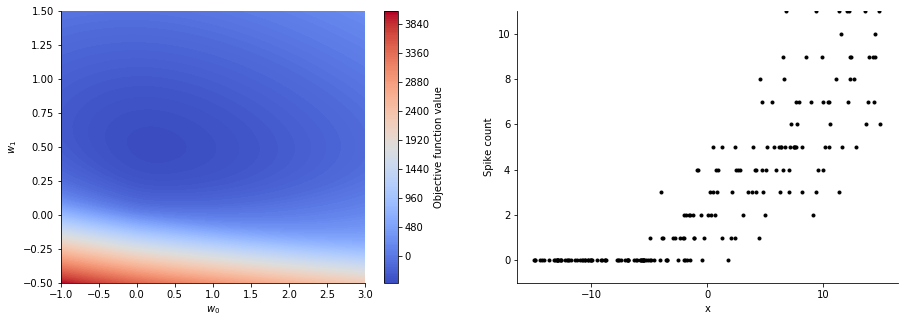

In [15]:
# Parameters
n = 200;
wTrue = [1, 0.5]
regLambda = 100

# Generate example data
x = np.random.rand(n)*30 - 15
x = np.sort(x)
X = np.vstack([np.ones(n), x]).T
mu = invLinkFun(X, wTrue)
y = np.random.poisson(mu)

# Evaluate the objective function over a grid
nGrid = 51
W0, W1 = np.meshgrid(np.linspace(wTrue[0]-2, wTrue[0]+2, nGrid), np.linspace(wTrue[1]-1, wTrue[1]+1, nGrid))
# Get the log-likelihood for each parameter combination
negLogLikVals = np.zeros([nGrid, nGrid])
for i in range(nGrid):
    for j in range(nGrid):
        wTmp = np.array([W0[i, j], W1[i, j]])
        negLogLikVals[i, j] = negLogLikFun(X, y, wTmp, regLambda)

# Plotting
def plotFun(W0, W1, funVals, X, y):
    fig = plt.figure(figsize=(15, 5))
    # Objective function surface
    ax_left = fig.add_subplot(1, 2, 1)
    contourHandle = ax_left.contourf(W0, W1, funVals, 150, cmap=cm.coolwarm)
    ax_left.set_xlabel('$w_0$')
    ax_left.set_ylabel('$w_1$')
    cBarHandle = plt.colorbar(contourHandle)
    cBarHandle.set_label('Objective function value');
    # Data
    ax_right = fig.add_subplot(1, 2, 2)
    ax_right.plot(x, y, 'k.', label='data')
    ax_right.set_ylabel('Spike count')
    ax_right.set_xlabel('x')
    ax_right.set_xticks([-10, 0, 10]);
    ax_right.set_ylim([-1, 11]);
    return ax_left, ax_right

plotFun(W0, W1, negLogLikVals, X, y);

### Vanilla proximal gradient

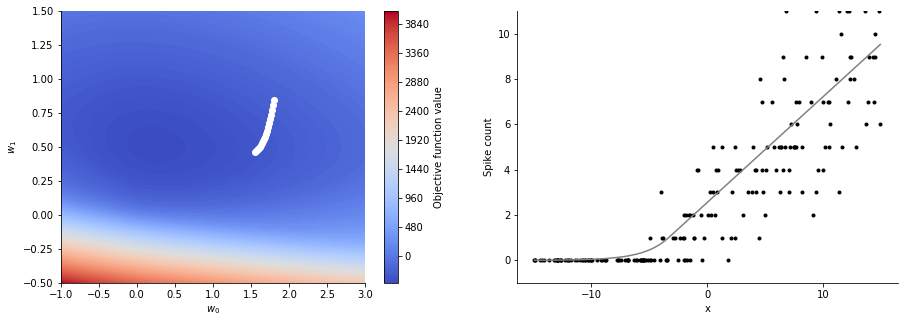

In [16]:
# Proximal gradient parameters
eta = 1e-4
nIterations = 20
wInit = np.array([1.8, 0.85])

wUpdates = np.zeros([nIterations, 2])
wUpdates[0, :] = wInit
objFunVals=np.zeros(nIterations)
objFunVals[0] = negLogLikFun(X, y, wUpdates[0, :], regLambda)

# Proximal gradient loop
for i in range(1, nIterations):
    gradTmp = gDerFun(X, y, wUpdates[i-1, :])
    wUpdates[i, :] = softThresholdingFun(wUpdates[i-1, :]- eta*gradTmp, regLambda*eta)
    objFunVals[i] = negLogLikFun(X, y, wUpdates[i, :], regLambda)
    
# Plotting
ax_left, ax_right = plotFun(W0, W1, negLogLikVals, X, y);
ax_left.plot(wUpdates[:, 0], wUpdates[:, 1], '-o', ms=6, color='white', lw=3)
ax_right.plot(X[:, 1], invLinkFun(X, wUpdates[i, :]), '-', color=0.5*np.ones(3));

### Acceleration and backtracking for proximal gradient
Acceleration and backtracking can be implemented as for normal gradient descent, but with a slight modification to the backtracking criteria. That is, acceleration is implemented by first taking a step along the previous update direction ($v_{k+1}$), and then a corrective proximal step ($w_{k+1}$):
\begin{align}
 \mathbf{v}_{k+1} &= \mathbf{w}_k + \frac{k-2}{k+1}(\mathbf{w}_k - \mathbf{w}_{k-1}), \\
 \mathbf{w}_{k+1} &= \mathbf{v}_{k+1} - \eta \nabla nll(\mathbf{v}_{k+1}). 
\end{align}
During the corrective proximal step, we again set $\eta$ through a backtracking procedure, where $\eta$ is decreased until the following condition is met:
$$
g(\mathbf{w}_{k+1})\leq g(\mathbf{v}_{k+1})+\nabla g(\mathbf{v}_{k+1})^T(\mathbf{w}_{k+1}-\mathbf{v}_{k+1})+\frac{1}{2\eta} ||\mathbf{w}_{k+1}-\mathbf{v}_{k+1}||^2
$$
The intuition behind this condition is that we do... FIX THIS STILL!!! and it simplifies to the condition used for gradient descent if $h$ is removed from the objective function.

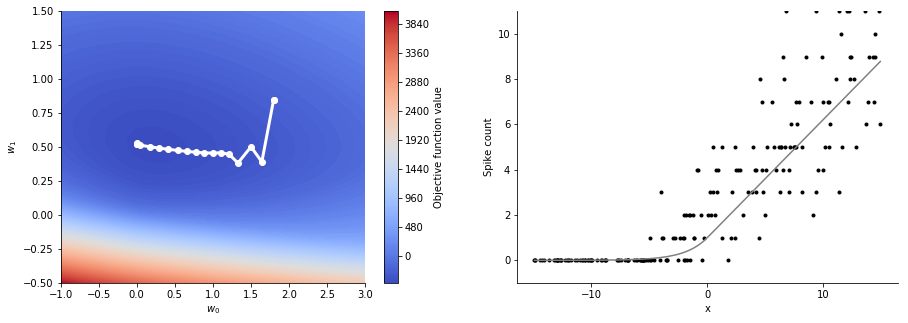

In [17]:
# Proximal gradient parameters
eta = 1e-1
beta = 0.8

wUpdates = np.zeros([nIterations, 2])
wUpdates[0:2, :] = wInit
wTmp = wUpdates[0, :]
objFunVals=np.zeros(nIterations)
objFunVals[0:2] = negLogLikFun(X, y, wUpdates[0, :], regLambda)

# Proximal gradient with backtracking and accerlation
for i in range(2, nIterations):
    gradTmp = gDerFun(X, y, wTmp)
    gTmp = gFun(X, y, wTmp)
    while True:
        wUpdates[i,:] = softThresholdingFun(wTmp - eta*gradTmp, regLambda*eta)
        diff = wUpdates[i,:] - wTmp
        if gFun(X, y, wUpdates[i,:]) > gTmp + np.dot(gradTmp, diff) + np.dot(diff, diff)/(2*eta):
            eta *= beta
        else:
            break
    objFunVals[i] = negLogLikFun(X, y, wUpdates[i,:], regLambda)
    wTmp = wUpdates[i,:] + (i-2)/(i+1)*(wUpdates[i,:] - wUpdates[i-1,:])

# Plotting
ax_left, ax_right = plotFun(W0, W1, negLogLikVals, X, y);
ax_left.plot(wUpdates[:, 0], wUpdates[:, 1], '-o', ms=6, color='white', lw=3)
ax_right.plot(X[:, 1], invLinkFun(X, wUpdates[i, :]), '-', color=0.5*np.ones(3));